In [ ]:
# подключение библиотек
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [ ]:
dts = '/content/drive/MyDrive/ШКОЛА/Конкурсы, проекты/ППО кейс Covid-19/dataset/'
file_plot = '/content/drive/MyDrive/ШКОЛА/Конкурсы, проекты/ППО кейс Covid-19/plot.png'
file_model = '/content/drive/MyDrive/ШКОЛА/Конкурсы, проекты/ППО кейс Covid-19/covid19.model'

In [ ]:
from google.colab import output

In [ ]:
# формирование облегченного учебного датасета из 100 снимков (50+50 изображений)

path_save = '/content/drive/MyDrive/ШКОЛА/Конкурсы, проекты/ППО кейс Covid-19/dataset/'
fn_X = path_save + 'X.npy'
X = np.load(fn_X)
fn_Y = path_save + 'Y.npy'
Y = np.load(fn_Y)
indexList = []
while len(indexList)<100:
  indexList = []
  for i in range(50):
    ind = np.random.randint(3560)
    if ind not in indexList:
      indexList.append(ind)
  for i in range(50):
    ind = np.random.randint(11000) + 3600
    if ind not in indexList:
      indexList.append(ind)  

X_new = np.array([])
Y_new = []
k = 0
for n in indexList:
  output.clear(); print(k,'%'); k += 1
  data_m = np.load(X[n])
  for i in range(data_m.shape[0]):
    for j in range(data_m.shape[1]):
      if data_m[i,j] < -2048: data_m[i,j] = -2048
      if data_m[i,j] > 2048: data_m[i,j] = 2048
  data_s = np.array([[[0]*3 for i in range(256)] for i in range(256)])
  for i in range(0,data_m.shape[0],2):
    for j in range(0,data_m.shape[1],2):
      c = data_m[i:i+2,j:j+2].max()
      data_s[i//2,j//2,0] = c
      data_s[i//2,j//2,1] = c 
      data_s[i//2,j//2,2] = c
  data_s = (data_s+2048)/4096
  if X_new.shape[0] == 0:
    X_new = data_s.reshape(1, 256, 256, 3)
  else:
    X_new = np.append(X_new, data_s.reshape(1, 256, 256, 3), axis = 0)
  Y_new.append(Y[n])
np.save(path_save+'X_new.npy',X_new)
np.save(path_save+'Y_new.npy',Y_new)
Y_new = to_categorical(Y_new)
print(X_new.shape, Y_new.shape)


99 %
(100, 256, 256, 3) (100, 2)


In [ ]:
(trainX, testX, trainY, testY) = train_test_split(X_new, Y_new,
	test_size=0.20, stratify=Y_new, random_state=42)

trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


10/10 [==============================] - 66s 7s/step - loss: 0.8065 - accuracy: 0.4015 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 2/25
10/10 [==============================] - 66s 7s/step - loss: 0.6906 - accuracy: 0.5632 - val_loss: 0.6881 - val_accuracy: 0.5000
Epoch 3/25
10/10 [==============================] - 66s 7s/step - loss: 0.7256 - accuracy: 0.5509 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/25
10/10 [==============================] - 66s 7s/step - loss: 0.7286 - accuracy: 0.4729 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 5/25
10/10 [==============================] - 65s 7s/step - loss: 0.7205 - accuracy: 0.4840 - val_loss: 0.6868 - val_accuracy: 0.5000
Epoch 6/25
10/10 [==============================] - 72s 7s/step - loss: 0.6905 - accuracy: 0.5469 - val_loss: 0.6869 - val_accuracy: 0.6500
Epoch 7/25
10/10 [==============================] - 66s 7s/step - loss: 0.6999 - accuracy: 0.5356 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 8/25
10/10 [=============

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['normal','covid']))
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[INFO] evaluating network...
              precision    recall  f1-score   support

      normal       0.53      0.80      0.64        10
       covid       0.60      0.30      0.40        10

    accuracy                           0.55        20
   macro avg       0.57      0.55      0.52        20
weighted avg       0.57      0.55      0.52        20

[[8 2]
 [7 3]]
acc: 0.5500
sensitivity: 0.8000
specificity: 0.3000


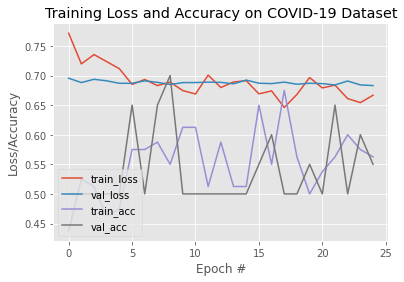

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()